# Mask Convolutional Neural Network for Multi-level Hierarchical Classification

In [ ]:
# To be run on Google Colab!
# !mkdir -p deakin/edu/au/
# !wget --directory-prefix=deakin/edu/au/  https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/data.py   > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/au/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/metrics.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/au/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/models.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/au/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/__init__.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/edu/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/__init__.py  > /dev/null 2> /dev/null 
# !wget --directory-prefix=deakin/ https://raw.githubusercontent.com/rbouadjenek/Masked-CNN/main/deakin/edu/au/__init__.py  > /dev/null 2> /dev/null 
# !pip install treelib > /dev/null 2> /dev/null 
# !pip install --upgrade scikit-learn > /dev/null 2> /dev/null 


In [1]:
from deakin.edu.au.data import Cifar100, Stanford_Cars, CU_Birds_200_2011
from deakin.edu.au import models 
from deakin.edu.au import utils 
import deakin.edu.au.metrics as metrics
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
import random
from tensorflow import keras
import collections, h5py
from tensorflow.python.keras.saving import hdf5_format


%load_ext autoreload
%autoreload 2
%load_ext tensorboard


2021-09-19 19:17:17.165288: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Loading data

## CIFAR100

In [12]:
#Load dataset
dataset = Cifar100()


## Stanford Cars

In [2]:
#Load dataset
dataset = Stanford_Cars(image_size=(64,64))


Preparing dataset...
Found 16185 files belonging to 1 classes.


2021-09-19 19:17:26.935229: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-19 19:17:27.018164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-09-19 19:17:27.018252: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-19 19:17:27.023598: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-19 19:17:27.023756: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-09-19 19:17:27.026165: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

Found 16185 files belonging to 1 classes.


## CU_Birds_200_2011

In [ ]:
#Load dataset
dataset = CU_Birds_200_2011(image_size=(64,64))


In [3]:
# plot the tree
tree = dataset.get_tree()
tree.show()
# Set variables
batch = 128
epochs = 100
# VGG-19
conv_base = 'vgg19'
learning_rate=1e-5
# NIN
# conv_base = 'nin'
# learning_rate=1e-3

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
performance_callback_val = models.performance_callback(dataset.X_val, 
                                                       dataset.y_val, 
                                                       dataset.get_tree(),
                                                       name='Validation set')

performance_callback_train = models.performance_callback(dataset.X_train, 
                                                         dataset.y_train, 
                                                         dataset.get_tree(),
                                                         name='Training set')


Root
├── Convertible -> (L0_0)
│   ├── Aston Convertible -> (L1_4)
│   │   ├── Aston Martin V8 Vantage Convertible 2012 -> (L2_7)
│   │   └── Aston Martin Virage Convertible 2012 -> (L2_9)
│   ├── Audi Convertible -> (L1_6)
│   │   ├── Audi RS 4 Convertible 2008 -> (L2_11)
│   │   └── Audi S5 Convertible 2012 -> (L2_20)
│   ├── BMW Convertible -> (L1_14)
│   │   ├── BMW 1 Series Convertible 2012 -> (L2_26)
│   │   ├── BMW 6 Series Convertible 2007 -> (L2_30)
│   │   ├── BMW M6 Convertible 2010 -> (L2_35)
│   │   └── BMW Z4 Convertible 2012 -> (L2_37)
│   ├── Bentley Convertible -> (L1_11)
│   │   └── Bentley Continental Supersports Conv. Convertible 2012 -> (L2_38)
│   ├── Bugatti Convertible -> (L1_19)
│   │   └── Bugatti Veyron 16.4 Convertible 2009 -> (L2_44)
│   ├── Chevrolet Convertible -> (L1_26)
│   │   ├── Chevrolet Camaro Convertible 2012 -> (L2_58)
│   │   └── Chevrolet Corvette Convertible 2012 -> (L2_54)
│   ├── Chrysler Convertible -> (L1_37)
│   │   ├── Chrysler Crossfire

# Visualization

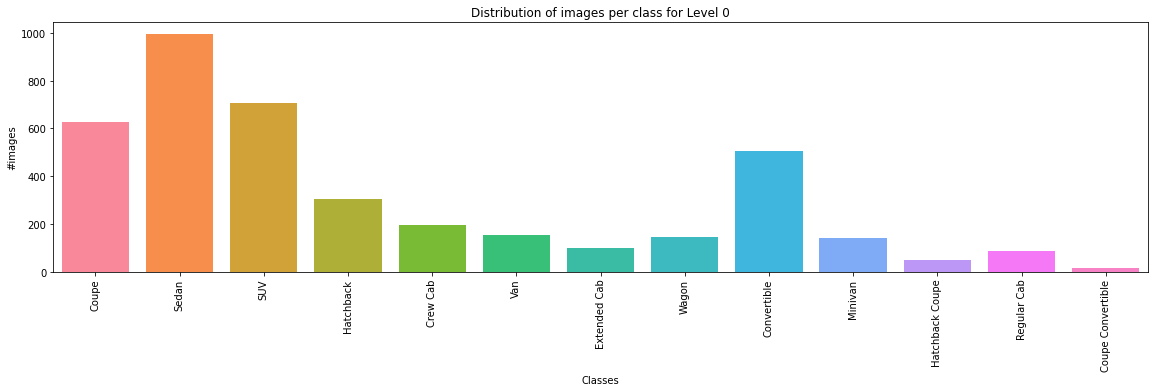

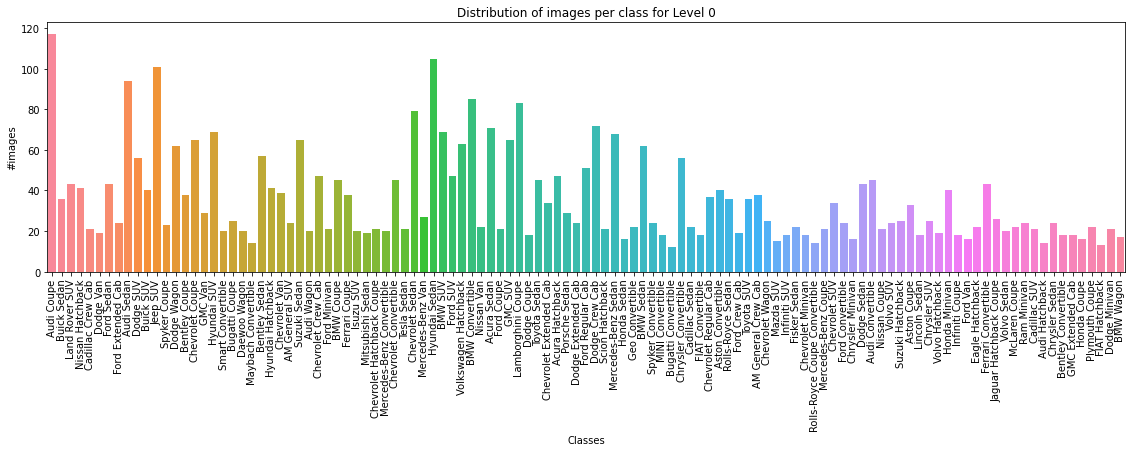

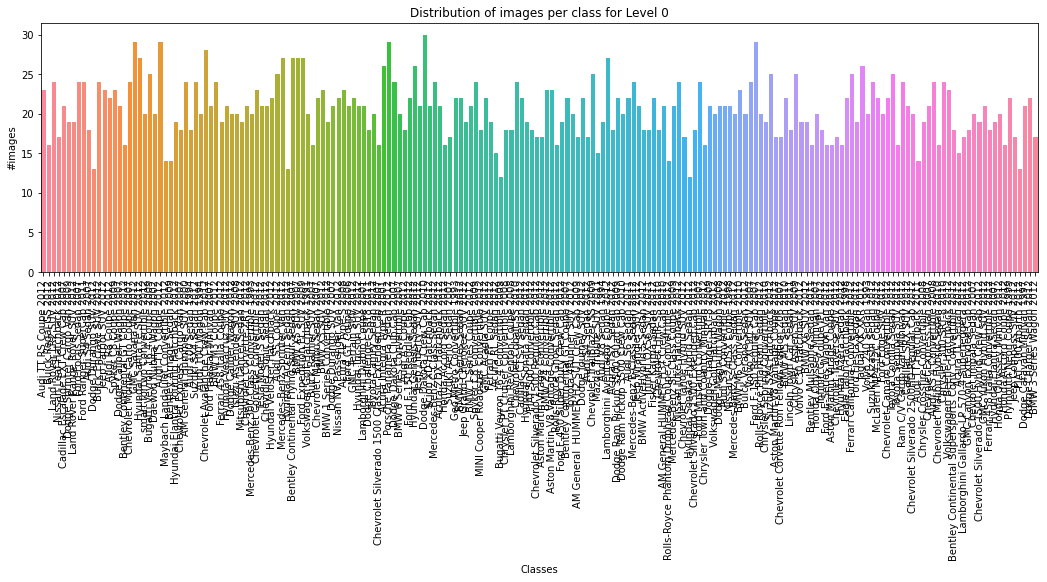

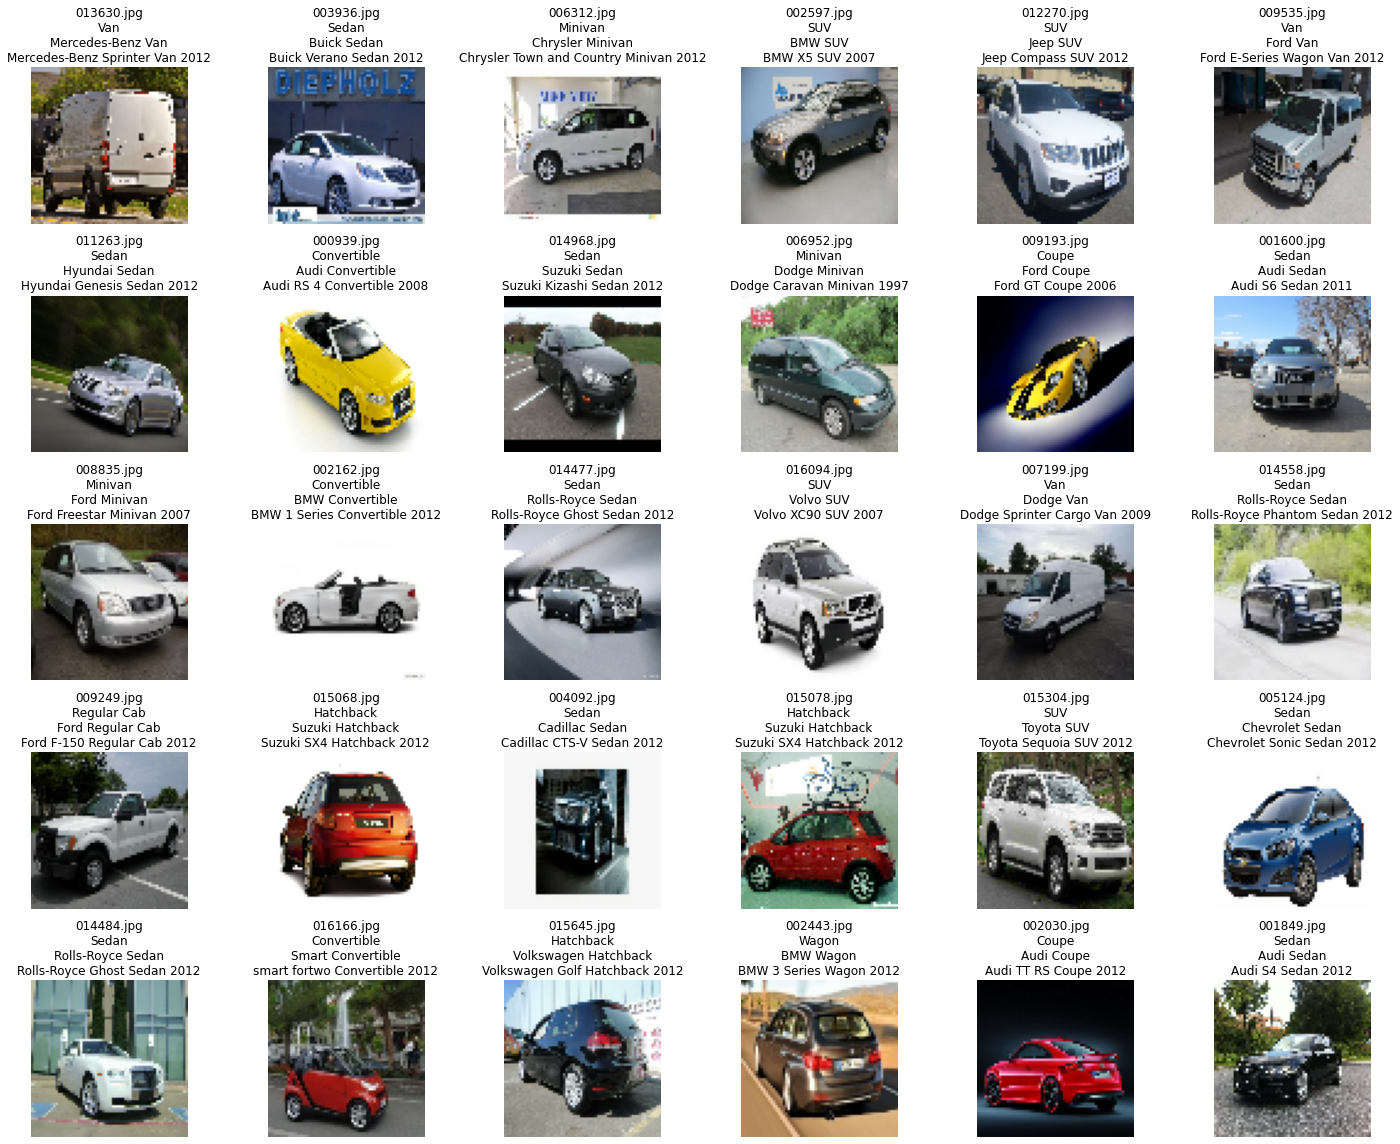

In [4]:
###############################################
#### Show distribution of images per class.
###############################################
counter=collections.Counter([x[0] for x in dataset.y_val[0]])
v = [ [dataset.labels[0][item[0]],item[1]]  for item in counter.items()]
df = pd.DataFrame(data=v, columns=['index','value'])
g = sns.catplot(x='index', y= 'value',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class for Level 0")
plt.xticks(rotation='vertical')
plt.show()
###############################################
#### Show distribution of images per class.
###############################################
counter=collections.Counter([x[0] for x in dataset.y_val[1]])
v = [ [dataset.labels[1][item[0]],item[1]]  for item in counter.items()]
df = pd.DataFrame(data=v, columns=['index','value'])
g = sns.catplot(x='index', y= 'value',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class for Level 0")
plt.xticks(rotation='vertical')
plt.show()
###############################################
#### Show distribution of images per class.
###############################################
counter=collections.Counter([x[0] for x in dataset.y_val[2]])
v = [ [dataset.labels[2][item[0]],item[1]]  for item in counter.items()]
df = pd.DataFrame(data=v, columns=['index','value'])
g = sns.catplot(x='index', y= 'value',  data=df, kind='bar', 
                legend=False,height=4,aspect=4,saturation=1)
(g.despine(top=False,right=False))
plt.xlabel("Classes")
plt.ylabel("#images")
plt.title("Distribution of images per class for Level 0")
plt.xticks(rotation='vertical')
plt.show()
###############################################
#### Examples of images.
###############################################

plt.figure(figsize=(20, 16))
for i in range(30):
    k = random.randint(0, len(dataset.X_val))
    file_name = dataset.val_filenames[k]
    y_l0 = dataset.labels[0][dataset.y_val[0][k][0]]
    y_l1 = dataset.labels[1][dataset.y_val[1][k][0]]
    y_l2 = dataset.labels[2][dataset.y_val[2][k][0]]

    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(dataset.X_val[k])
    plt.title(file_name + "\n" + y_l0 + "\n" + y_l1 + "\n" + y_l2)
    plt.axis("off")

plt.tight_layout() 
plt.show()


# Training all models

Model: "mnets"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_base0 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base1 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base2 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
______________________________________________________________________________________________

2021-09-19 19:20:03.579736: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-09-19 19:20:04.030865: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-09-19 19:20:04.666814: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-19 19:20:05.090274: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


64/64 [==============================] - 26s 295ms/step - loss: 7.6575 - out_level_0_loss: 5.1986 - out_level_1_loss: 8.5218 - out_level_2_loss: 9.2520 - out_level_0_accuracy: 0.1632 - out_level_1_accuracy: 0.0083 - out_level_2_accuracy: 0.0053 - val_loss: 4.1405 - val_out_level_0_loss: 2.3101 - val_out_level_1_loss: 4.7823 - val_out_level_2_loss: 5.3291 - val_out_level_0_accuracy: 0.2020 - val_out_level_1_accuracy: 0.0080 - val_out_level_2_accuracy: 0.0052
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0025 |       -        |   -    |
|  h-Precision   | 0.0782 |    h-Recall    | 0.1458 |   h-

64/64 [==============================] - 15s 237ms/step - loss: 3.8120 - out_level_0_loss: 1.6976 - out_level_1_loss: 4.5122 - out_level_2_loss: 5.2262 - out_level_0_accuracy: 0.4177 - out_level_1_accuracy: 0.0457 - out_level_2_accuracy: 0.0133 - val_loss: 3.9090 - val_out_level_0_loss: 1.8629 - val_out_level_1_loss: 4.5847 - val_out_level_2_loss: 5.2792 - val_out_level_0_accuracy: 0.3475 - val_out_level_1_accuracy: 0.0418 - val_out_level_2_accuracy: 0.0057
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0072 |       -        |   -    |
|  h-Precision   | 0.1081 |    h-Recall    | 0.1869 |   h-

64/64 [==============================] - 15s 236ms/step - loss: 3.3584 - out_level_0_loss: 1.1011 - out_level_1_loss: 3.9716 - out_level_2_loss: 5.0024 - out_level_0_accuracy: 0.6278 - out_level_1_accuracy: 0.1198 - out_level_2_accuracy: 0.0319 - val_loss: 3.8589 - val_out_level_0_loss: 1.8653 - val_out_level_1_loss: 4.4285 - val_out_level_2_loss: 5.2829 - val_out_level_0_accuracy: 0.3960 - val_out_level_1_accuracy: 0.0639 - val_out_level_2_accuracy: 0.0164
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0015 |  Consistency   | 0.0104 |       -        |   -    |
|  h-Precision   | 0.1312 |    h-Recall    | 0.2228 |   h-

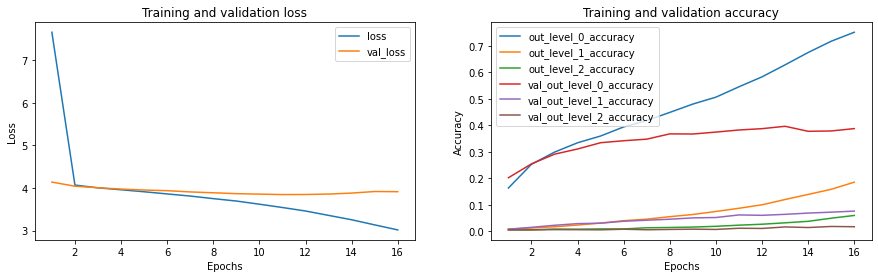

2021-09-19 19:25:11.654189: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/mnets_model_stanford_cars_vgg19/assets


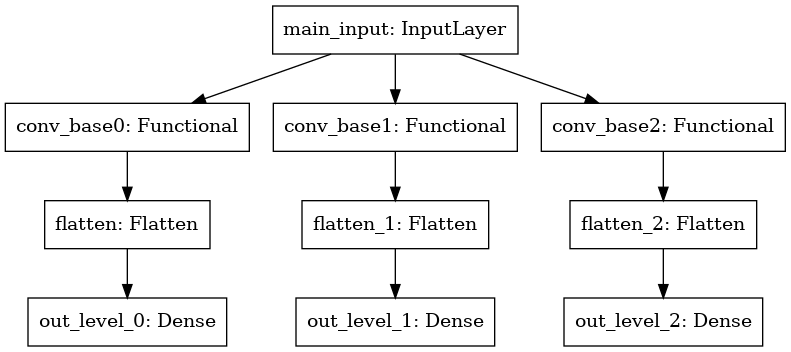

In [5]:
# Create the model
mnets_model = models.get_mnets(dataset.num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base,
                               learning_rate=learning_rate)
mnets_model.summary()
#train model
history_mnets_model = mnets_model.fit(dataset.X_train, 
                                      dataset.y_train,
                                      validation_data = (dataset.X_val, dataset.y_val), 
                                      batch_size=batch, 
                                      epochs=epochs,
                                      callbacks=[performance_callback_val, early_stopping_callback])
utils.learning_plots(history_mnets_model)
mnets_model.save("models/mnets_model_" + dataset.name + "_" + conv_base)
plot_model(mnets_model)

# with h5py.File("models/mnets_model_" + dataset.name + "_" + conv_base + "model.h5", mode='w') as f:
#     hdf5_format.save_model_to_hdf5(mnets_model, f)



Total improvement:  [173, 994, 1323]
Left to right improvement:  [173, 65, 0]
Right to left improvement:  [0, 929, 1323]


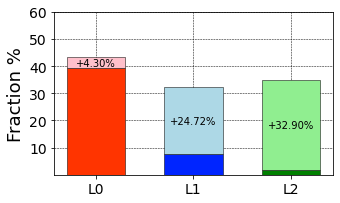

In [6]:
mnets_model_pred = mnets_model.predict(dataset.X_test)
mnets_model_accuracy = metrics.get_top_k_taxonomical_accuracy(dataset.y_test, mnets_model_pred)
mnets_model_accuracy = [x * 100 for x in mnets_model_accuracy]
oracle_accuracy = utils.get_potential_improvement(dataset.y_test, 
                                                  mnets_model_pred,
                                                  dataset.taxonomy)
plt = utils.plot_potential_improvement(oracle_accuracy, mnets_model_accuracy)
ax = plt.gca()
ax.set_ylim(0, 60)
plt.savefig('plots/oracle_' + dataset.name + '_' + conv_base + '.eps', bbox_inches = 'tight')
plt.show()


Model: "mout_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_level_0 (Dense)             (None, 13)           26637       flatten_3[0][0]                  
_________________________________________________________________________________________

64/64 [==============================] - 6s 87ms/step - loss: 4.0682 - out_level_0_loss: 2.1556 - out_level_1_loss: 4.7224 - out_level_2_loss: 5.3267 - out_level_0_accuracy: 0.2890 - out_level_1_accuracy: 0.0193 - out_level_2_accuracy: 0.0060 - val_loss: 4.0805 - val_out_level_0_loss: 2.1695 - val_out_level_1_loss: 4.7380 - val_out_level_2_loss: 5.3341 - val_out_level_0_accuracy: 0.2843 - val_out_level_1_accuracy: 0.0199 - val_out_level_2_accuracy: 0.0050
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0010 |       -        |   -    |
|  h-Precision   | 0.0859 |    h-Recall    | 0.1514 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 3.8979 - out_level_0_loss: 1.8832 - out_level_1_loss: 4.5720 - out_level_2_loss: 5.2384 - out_level_0_accuracy: 0.3759 - out_level_1_accuracy: 0.0452 - out_level_2_accuracy: 0.0140 - val_loss: 3.9526 - val_out_level_0_loss: 1.9177 - val_out_level_1_loss: 4.6318 - val_out_level_2_loss: 5.3083 - val_out_level_0_accuracy: 0.3535 - val_out_level_1_accuracy: 0.0378 - val_out_level_2_accuracy: 0.0075
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0072 |       -        |   -    |
|  h-Precision   | 0.1084 |    h-Recall    | 0.1892 |   h-F1

64/64 [==============================] - 5s 86ms/step - loss: 3.5961 - out_level_0_loss: 1.6029 - out_level_1_loss: 4.2190 - out_level_2_loss: 4.9665 - out_level_0_accuracy: 0.4573 - out_level_1_accuracy: 0.0866 - out_level_2_accuracy: 0.0328 - val_loss: 3.8001 - val_out_level_0_loss: 1.7788 - val_out_level_1_loss: 4.4449 - val_out_level_2_loss: 5.1767 - val_out_level_0_accuracy: 0.3970 - val_out_level_1_accuracy: 0.0562 - val_out_level_2_accuracy: 0.0211
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0035 |  Consistency   | 0.0438 |       -        |   -    |
|  h-Precision   | 0.1349 |    h-Recall    | 0.2179 |   h-F1

64/64 [==============================] - 6s 86ms/step - loss: 3.1180 - out_level_0_loss: 1.2500 - out_level_1_loss: 3.6562 - out_level_2_loss: 4.4479 - out_level_0_accuracy: 0.5754 - out_level_1_accuracy: 0.1658 - out_level_2_accuracy: 0.0821 - val_loss: 3.7132 - val_out_level_0_loss: 1.7502 - val_out_level_1_loss: 4.2998 - val_out_level_2_loss: 5.0897 - val_out_level_0_accuracy: 0.4246 - val_out_level_1_accuracy: 0.0799 - val_out_level_2_accuracy: 0.0323
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0082 |  Consistency   | 0.0706 |       -        |   -    |
|  h-Precision   | 0.1580 |    h-Recall    | 0.2429 |   h-F1

64/64 [==============================] - 6s 86ms/step - loss: 2.4315 - out_level_0_loss: 0.8535 - out_level_1_loss: 2.8405 - out_level_2_loss: 3.6004 - out_level_0_accuracy: 0.7105 - out_level_1_accuracy: 0.3114 - out_level_2_accuracy: 0.2005 - val_loss: 3.7823 - val_out_level_0_loss: 1.8576 - val_out_level_1_loss: 4.3537 - val_out_level_2_loss: 5.1356 - val_out_level_0_accuracy: 0.4286 - val_out_level_1_accuracy: 0.0960 - val_out_level_2_accuracy: 0.0475
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0107 |  Consistency   | 0.0701 |       -        |   -    |
|  h-Precision   | 0.1758 |    h-Recall    | 0.2677 |   h-F1

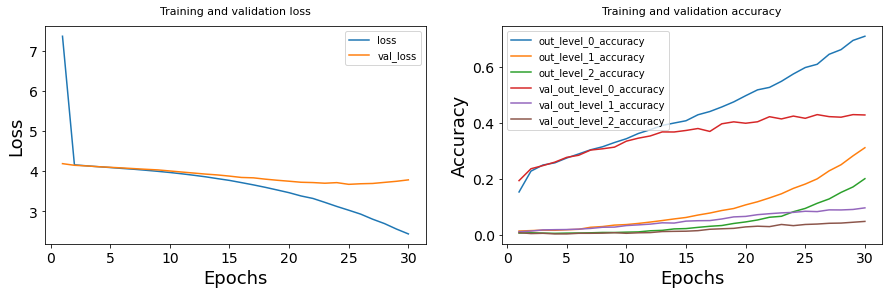

INFO:tensorflow:Assets written to: models/mout_model_stanford_cars_vgg19/assets


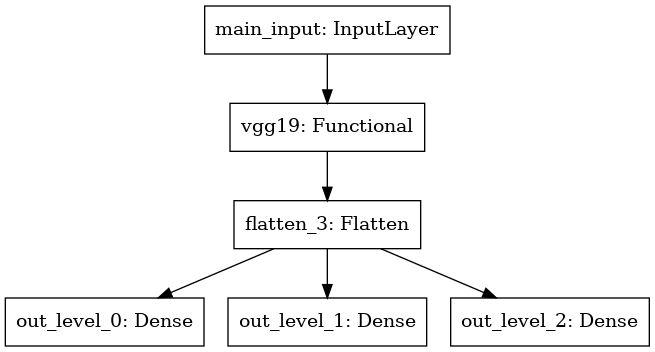

In [7]:
# Create the model
mout_model = models.get_mout_model(dataset.num_classes, 
                                   dataset.image_size, 
                                   conv_base=conv_base,
                                   learning_rate=learning_rate)
mout_model.summary()
#train model
history_mout_model = mout_model.fit(dataset.X_train, 
                                    dataset.y_train,
                                    validation_data = (dataset.X_val, dataset.y_val),
                                    batch_size=batch, 
                                    epochs=epochs,
                                    callbacks=[performance_callback_val, early_stopping_callback])
utils.learning_plots(history_mout_model)
mout_model.save("models/mout_model_" + dataset.name + "_" + conv_base)
plot_model(mout_model)


Model: "Model_BCNN1_reversed_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
out_level_0 (Dense)          (None, 13)                26637     
_________________________________________________________________
out_level_1 (Dense)          (None, 113)               1582      
_________________________________________________________________
out_level_2 (Dense)          (None, 196)               22344     
Total params: 20,074,947
Trainable params: 20,074,947
Non-trainable params: 0
____________________________

64/64 [==============================] - 6s 86ms/step - loss: 3.9370 - out_level_0_loss: 1.8082 - out_level_1_loss: 4.7247 - out_level_2_loss: 5.2781 - out_level_0_accuracy: 0.3832 - out_level_1_accuracy: 0.0099 - out_level_2_accuracy: 0.0049 - val_loss: 3.9666 - val_out_level_0_loss: 1.8962 - val_out_level_1_loss: 4.7255 - val_out_level_2_loss: 5.2780 - val_out_level_0_accuracy: 0.3550 - val_out_level_1_accuracy: 0.0107 - val_out_level_2_accuracy: 0.0042
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0000 |       -        |   -    |
|  h-Precision   | 0.0996 |    h-Recall    | 0.1687 |   h-F1

64/64 [==============================] - 5s 86ms/step - loss: 3.7696 - out_level_0_loss: 1.3159 - out_level_1_loss: 4.7148 - out_level_2_loss: 5.2780 - out_level_0_accuracy: 0.5463 - out_level_1_accuracy: 0.0122 - out_level_2_accuracy: 0.0031 - val_loss: 3.9163 - val_out_level_0_loss: 1.7511 - val_out_level_1_loss: 4.7200 - val_out_level_2_loss: 5.2779 - val_out_level_0_accuracy: 0.4007 - val_out_level_1_accuracy: 0.0097 - val_out_level_2_accuracy: 0.0025
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0000 |       -        |   -    |
|  h-Precision   | 0.1060 |    h-Recall    | 0.1909 |   h-F1

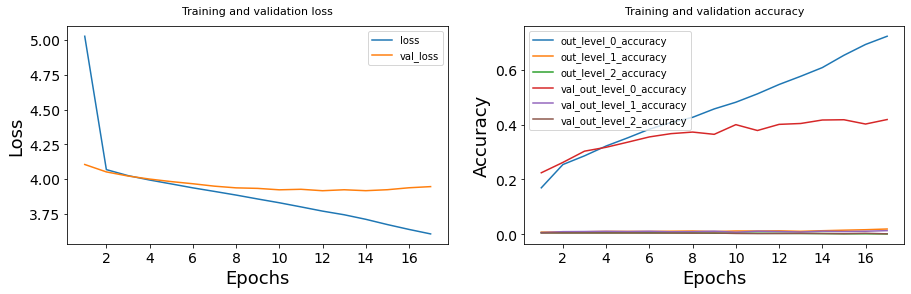

INFO:tensorflow:Assets written to: models/BCNN1_model_stanford_cars_vgg19/assets


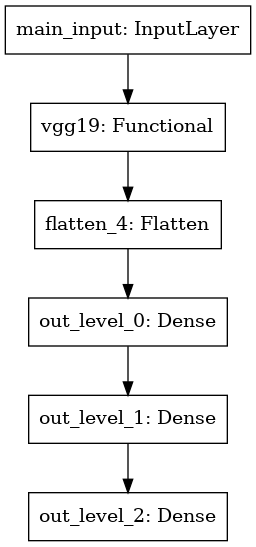

In [8]:
# Create the model
BCNN1_model = models.get_BCNN1(dataset.num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base,
                               learning_rate=learning_rate)
BCNN1_model.summary()
#train model
history_BCNN1_model = BCNN1_model.fit(dataset.X_train, 
                                      dataset.y_train,
                                      validation_data = (dataset.X_val, dataset.y_val),
                                      batch_size=batch, 
                                      epochs=epochs,
                                      callbacks=[performance_callback_val, early_stopping_callback])
utils.learning_plots(history_BCNN1_model)
BCNN1_model.save("models/BCNN1_model_" + dataset.name + "_" + conv_base)
plot_model(BCNN1_model)


Model: "Model_BCNN1_reversed_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
out_level_2 (Dense)          (None, 196)               401604    
_________________________________________________________________
out_level_1 (Dense)          (None, 113)               22261     
_________________________________________________________________
out_level_0 (Dense)          (None, 13)                1482      
Total params: 20,449,731
Trainable params: 20,449,731
Non-trainable params: 0
_____________________________

64/64 [==============================] - 5s 86ms/step - loss: 4.1784 - out_level_0_loss: 2.5581 - out_level_1_loss: 4.7253 - out_level_2_loss: 5.2520 - out_level_0_accuracy: 0.1764 - out_level_1_accuracy: 0.0216 - out_level_2_accuracy: 0.0091 - val_loss: 4.1878 - val_out_level_0_loss: 2.5577 - val_out_level_1_loss: 4.7252 - val_out_level_2_loss: 5.2806 - val_out_level_0_accuracy: 0.1759 - val_out_level_1_accuracy: 0.0219 - val_out_level_2_accuracy: 0.0085
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0000 |       -        |   -    |
|  h-Precision   | 0.0785 |    h-Recall    | 0.1494 |   h-F1

64/64 [==============================] - 5s 86ms/step - loss: 4.1345 - out_level_0_loss: 2.5523 - out_level_1_loss: 4.7235 - out_level_2_loss: 5.1279 - out_level_0_accuracy: 0.1764 - out_level_1_accuracy: 0.0236 - out_level_2_accuracy: 0.0203 - val_loss: 4.1810 - val_out_level_0_loss: 2.5520 - val_out_level_1_loss: 4.7233 - val_out_level_2_loss: 5.2677 - val_out_level_0_accuracy: 0.1759 - val_out_level_1_accuracy: 0.0256 - val_out_level_2_accuracy: 0.0102
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0000 |       -        |   -    |
|  h-Precision   | 0.0839 |    h-Recall    | 0.1590 |   h-F1

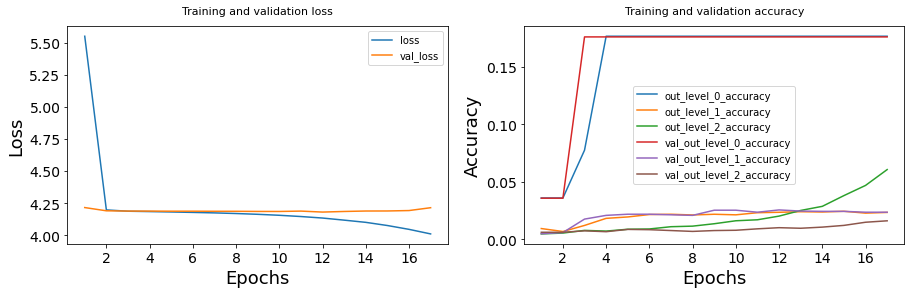

INFO:tensorflow:Assets written to: models/BCNN1_reversed_model_stanford_cars_vgg19/assets


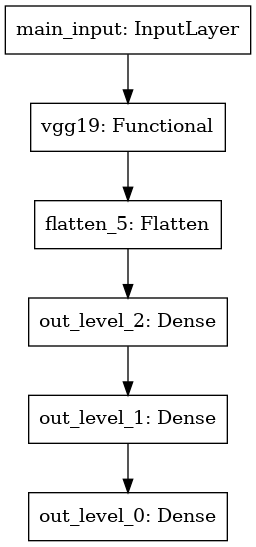

In [9]:
# Create the model
BCNN1_reversed_model = models.get_BCNN1(dataset.num_classes, 
                                        dataset.image_size, 
                                        reverse=True, 
                                        conv_base=conv_base, 
                                        learning_rate=learning_rate)
BCNN1_reversed_model.summary()
#train model
history_BCNN1_reversed_model = BCNN1_reversed_model.fit(dataset.X_train, 
                                                        dataset.y_train,
                                                        validation_data = (dataset.X_val, dataset.y_val),
                                                        batch_size=batch, 
                                                        epochs=epochs,
                                                        callbacks=[performance_callback_val, early_stopping_callback])
utils.learning_plots(history_BCNN1_reversed_model)
BCNN1_reversed_model.save("models/BCNN1_reversed_model_" + dataset.name + "_" + conv_base)
plot_model(BCNN1_reversed_model)


Model: "Model_BCNN2_reversed_False"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_0 (Dense)          (None, 13)           26637       flatten_6[0][0]                  
_________________________________________________________________________

64/64 [==============================] - 5s 86ms/step - loss: 4.0623 - out_level_0_loss: 2.0925 - out_level_1_loss: 4.7824 - out_level_2_loss: 5.3121 - out_level_0_accuracy: 0.3139 - out_level_1_accuracy: 0.0115 - out_level_2_accuracy: 0.0063 - val_loss: 4.0681 - val_out_level_0_loss: 2.0969 - val_out_level_1_loss: 4.7991 - val_out_level_2_loss: 5.3083 - val_out_level_0_accuracy: 0.3085 - val_out_level_1_accuracy: 0.0085 - val_out_level_2_accuracy: 0.0085
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0000 |       -        |   -    |
|  h-Precision   | 0.0987 |    h-Recall    | 0.1764 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 3.9744 - out_level_0_loss: 1.8582 - out_level_1_loss: 4.7729 - out_level_2_loss: 5.2922 - out_level_0_accuracy: 0.3972 - out_level_1_accuracy: 0.0131 - out_level_2_accuracy: 0.0060 - val_loss: 4.0235 - val_out_level_0_loss: 1.9495 - val_out_level_1_loss: 4.8110 - val_out_level_2_loss: 5.3101 - val_out_level_0_accuracy: 0.3560 - val_out_level_1_accuracy: 0.0080 - val_out_level_2_accuracy: 0.0072
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0002 |       -        |   -    |
|  h-Precision   | 0.1013 |    h-Recall    | 0.1796 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 3.8291 - out_level_0_loss: 1.5447 - out_level_1_loss: 4.7215 - out_level_2_loss: 5.2212 - out_level_0_accuracy: 0.5037 - out_level_1_accuracy: 0.0196 - out_level_2_accuracy: 0.0107 - val_loss: 3.9994 - val_out_level_0_loss: 1.8723 - val_out_level_1_loss: 4.8281 - val_out_level_2_loss: 5.2979 - val_out_level_0_accuracy: 0.3716 - val_out_level_1_accuracy: 0.0082 - val_out_level_2_accuracy: 0.0075
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0017 |       -        |   -    |
|  h-Precision   | 0.1042 |    h-Recall    | 0.1849 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 3.5763 - out_level_0_loss: 1.1007 - out_level_1_loss: 4.5882 - out_level_2_loss: 5.0399 - out_level_0_accuracy: 0.6597 - out_level_1_accuracy: 0.0370 - out_level_2_accuracy: 0.0193 - val_loss: 4.0411 - val_out_level_0_loss: 1.9790 - val_out_level_1_loss: 4.8716 - val_out_level_2_loss: 5.2727 - val_out_level_0_accuracy: 0.3910 - val_out_level_1_accuracy: 0.0134 - val_out_level_2_accuracy: 0.0087
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0005 |  Consistency   | 0.0052 |       -        |   -    |
|  h-Precision   | 0.1116 |    h-Recall    | 0.1951 |   h-F1

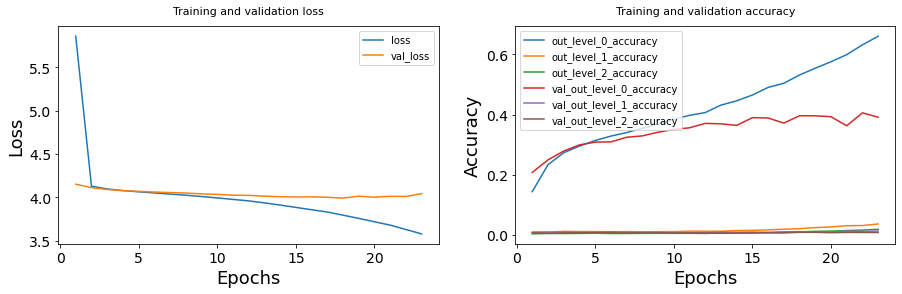

INFO:tensorflow:Assets written to: models/BCNN2_model_stanford_cars_vgg19/assets


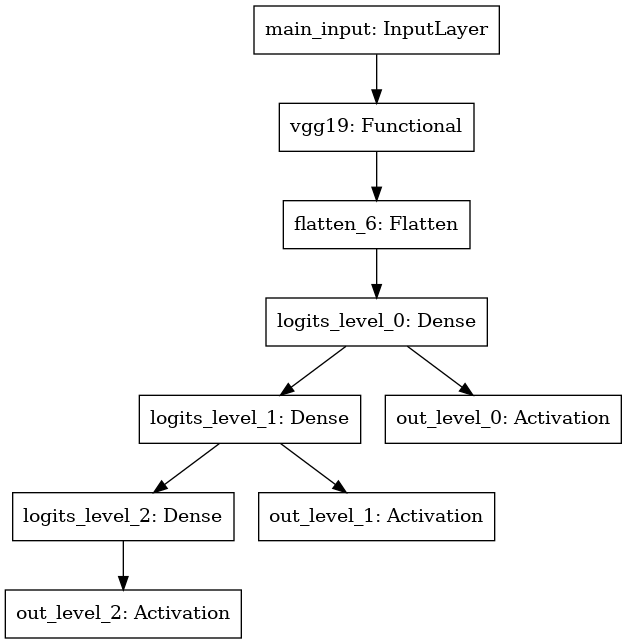

In [10]:
# Create the model
BCNN2_model = models.get_BCNN2(dataset.num_classes, 
                               dataset.image_size, 
                               conv_base=conv_base, 
                               learning_rate=learning_rate)
BCNN2_model.summary()
#train model
history_BCNN2_model = BCNN2_model.fit(dataset.X_train, 
                                      dataset.y_train,
                                      validation_data = (dataset.X_val, dataset.y_val), 
                                      batch_size=batch,
                                      epochs=epochs,
                                      callbacks=[performance_callback_val, early_stopping_callback])
utils.learning_plots(history_BCNN2_model)
BCNN2_model.save("models/BCNN2_model_" + dataset.name + "_" + conv_base)
plot_model(BCNN2_model)


Model: "Model_BCNN2_reversed_True"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 2048)         0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_2 (Dense)          (None, 196)          401604      flatten_7[0][0]                  
__________________________________________________________________________

64/64 [==============================] - 5s 86ms/step - loss: 4.0793 - out_level_0_loss: 2.1598 - out_level_1_loss: 4.7587 - out_level_2_loss: 5.3195 - out_level_0_accuracy: 0.2852 - out_level_1_accuracy: 0.0139 - out_level_2_accuracy: 0.0064 - val_loss: 4.0778 - val_out_level_0_loss: 2.1516 - val_out_level_1_loss: 4.7576 - val_out_level_2_loss: 5.3242 - val_out_level_0_accuracy: 0.2803 - val_out_level_1_accuracy: 0.0122 - val_out_level_2_accuracy: 0.0072
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0827 |    h-Recall    | 0.1541 |   h-F1

64/64 [==============================] - 5s 86ms/step - loss: 3.9558 - out_level_0_loss: 1.9094 - out_level_1_loss: 4.6700 - out_level_2_loss: 5.2881 - out_level_0_accuracy: 0.3593 - out_level_1_accuracy: 0.0231 - out_level_2_accuracy: 0.0076 - val_loss: 3.9889 - val_out_level_0_loss: 1.9374 - val_out_level_1_loss: 4.7083 - val_out_level_2_loss: 5.3211 - val_out_level_0_accuracy: 0.3420 - val_out_level_1_accuracy: 0.0211 - val_out_level_2_accuracy: 0.0070
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0042 |       -        |   -    |
|  h-Precision   | 0.0975 |    h-Recall    | 0.1824 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 3.8030 - out_level_0_loss: 1.6864 - out_level_1_loss: 4.4808 - out_level_2_loss: 5.2417 - out_level_0_accuracy: 0.4314 - out_level_1_accuracy: 0.0507 - out_level_2_accuracy: 0.0103 - val_loss: 3.9011 - val_out_level_0_loss: 1.7976 - val_out_level_1_loss: 4.5839 - val_out_level_2_loss: 5.3218 - val_out_level_0_accuracy: 0.3848 - val_out_level_1_accuracy: 0.0371 - val_out_level_2_accuracy: 0.0095
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0002 |  Consistency   | 0.0132 |       -        |   -    |
|  h-Precision   | 0.1130 |    h-Recall    | 0.1978 |   h-F1

64/64 [==============================] - 5s 86ms/step - loss: 3.5797 - out_level_0_loss: 1.4384 - out_level_1_loss: 4.1673 - out_level_2_loss: 5.1333 - out_level_0_accuracy: 0.5091 - out_level_1_accuracy: 0.0928 - out_level_2_accuracy: 0.0225 - val_loss: 3.8699 - val_out_level_0_loss: 1.7944 - val_out_level_1_loss: 4.4964 - val_out_level_2_loss: 5.3189 - val_out_level_0_accuracy: 0.3913 - val_out_level_1_accuracy: 0.0527 - val_out_level_2_accuracy: 0.0134
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0152 |       -        |   -    |
|  h-Precision   | 0.1249 |    h-Recall    | 0.2119 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 3.2360 - out_level_0_loss: 1.1272 - out_level_1_loss: 3.7058 - out_level_2_loss: 4.8750 - out_level_0_accuracy: 0.6214 - out_level_1_accuracy: 0.1644 - out_level_2_accuracy: 0.0487 - val_loss: 3.8403 - val_out_level_0_loss: 1.8122 - val_out_level_1_loss: 4.3539 - val_out_level_2_loss: 5.3549 - val_out_level_0_accuracy: 0.4107 - val_out_level_1_accuracy: 0.0764 - val_out_level_2_accuracy: 0.0174
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0022 |  Consistency   | 0.0303 |       -        |   -    |
|  h-Precision   | 0.1404 |    h-Recall    | 0.2317 |   h-F1

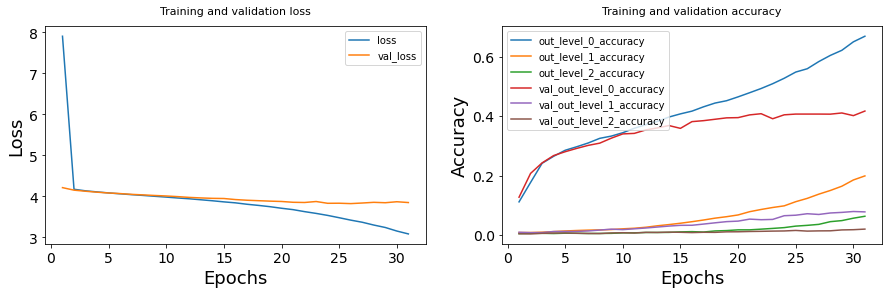

INFO:tensorflow:Assets written to: models/BCNN2_reversed_model_stanford_cars_vgg19/assets


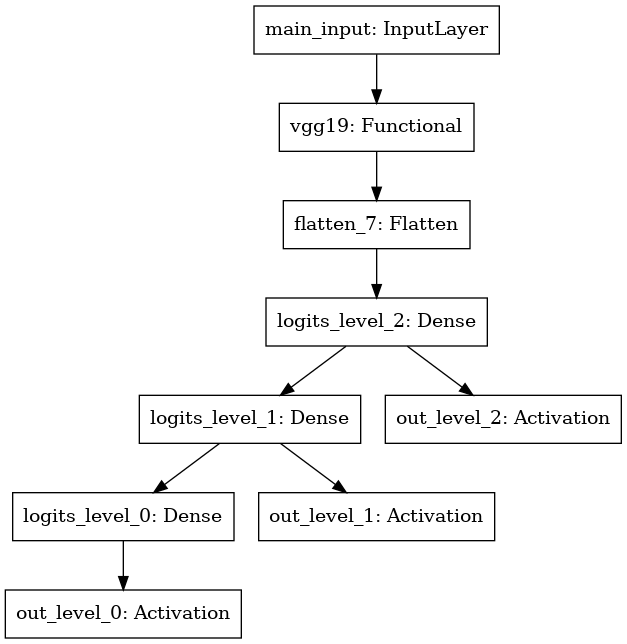

In [11]:
# Create the model
BCNN2_reversed_model = models.get_BCNN2(dataset.num_classes, 
                                        dataset.image_size, 
                                        reverse=True, 
                                        conv_base=conv_base,
                                        learning_rate=learning_rate)
BCNN2_reversed_model.summary()
#train model
history_BCNN2_reversed_model = BCNN2_reversed_model.fit(dataset.X_train, 
                                                        dataset.y_train,
                                                        validation_data = (dataset.X_val, dataset.y_val), 
                                                        batch_size=batch, 
                                                        epochs=epochs,
                                                        callbacks=[performance_callback_val, early_stopping_callback])
utils.learning_plots(history_BCNN2_reversed_model)
BCNN2_reversed_model.save("models/BCNN2_reversed_model_" + dataset.name + "_" + conv_base)
plot_model(BCNN2_reversed_model)


Model: "MLPH_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, None, None,  17664576    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 8192)         0           model[0][0]                      
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 8192)         0           model[0][1]                      
_________________________________________________________________________________________

64/64 [==============================] - 5s 85ms/step - loss: 541.9258 - out_level_0_loss: 367.6377 - out_level_1_loss: 608.3340 - out_level_2_loss: 649.8052 - out_level_0_accuracy: 0.1152 - out_level_1_accuracy: 0.0104 - out_level_2_accuracy: 0.0049 - val_loss: 427.9901 - val_out_level_0_loss: 295.3799 - val_out_level_1_loss: 477.1902 - val_out_level_2_loss: 511.4002 - val_out_level_0_accuracy: 0.1236 - val_out_level_1_accuracy: 0.0087 - val_out_level_2_accuracy: 0.0057
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0007 |       -        |   -    |
|  h-Precision   | 0.0668 |    h-Recall    |

64/64 [==============================] - 5s 85ms/step - loss: 49.6792 - out_level_0_loss: 34.1066 - out_level_1_loss: 55.7195 - out_level_2_loss: 59.2116 - out_level_0_accuracy: 0.1217 - out_level_1_accuracy: 0.0108 - out_level_2_accuracy: 0.0063 - val_loss: 44.6158 - val_out_level_0_loss: 31.8857 - val_out_level_1_loss: 49.1242 - val_out_level_2_loss: 52.8377 - val_out_level_0_accuracy: 0.1204 - val_out_level_1_accuracy: 0.0090 - val_out_level_2_accuracy: 0.0065
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0010 |       -        |   -    |
|  h-Precision   | 0.0666 |    h-Recall    | 0.1260 

64/64 [==============================] - 5s 86ms/step - loss: 10.4332 - out_level_0_loss: 7.1488 - out_level_1_loss: 11.6315 - out_level_2_loss: 12.5191 - out_level_0_accuracy: 0.1078 - out_level_1_accuracy: 0.0109 - out_level_2_accuracy: 0.0068 - val_loss: 10.8080 - val_out_level_0_loss: 7.8196 - val_out_level_1_loss: 11.7451 - val_out_level_2_loss: 12.8592 - val_out_level_0_accuracy: 0.1070 - val_out_level_1_accuracy: 0.0149 - val_out_level_2_accuracy: 0.0037
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0015 |       -        |   -    |
|  h-Precision   | 0.0621 |    h-Recall    | 0.1158 | 

64/64 [==============================] - 5s 86ms/step - loss: 6.1120 - out_level_0_loss: 3.9554 - out_level_1_loss: 6.8445 - out_level_2_loss: 7.5362 - out_level_0_accuracy: 0.1570 - out_level_1_accuracy: 0.0161 - out_level_2_accuracy: 0.0063 - val_loss: 6.6997 - val_out_level_0_loss: 4.6790 - val_out_level_1_loss: 7.3439 - val_out_level_2_loss: 8.0761 - val_out_level_0_accuracy: 0.1545 - val_out_level_1_accuracy: 0.0169 - val_out_level_2_accuracy: 0.0035
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0688 |    h-Recall    | 0.1227 |   h-F1

64/64 [==============================] - 5s 84ms/step - loss: 5.0219 - out_level_0_loss: 3.1460 - out_level_1_loss: 5.6375 - out_level_2_loss: 6.2822 - out_level_0_accuracy: 0.1977 - out_level_1_accuracy: 0.0198 - out_level_2_accuracy: 0.0053 - val_loss: 5.5554 - val_out_level_0_loss: 3.7167 - val_out_level_1_loss: 6.1669 - val_out_level_2_loss: 6.7826 - val_out_level_0_accuracy: 0.1856 - val_out_level_1_accuracy: 0.0199 - val_out_level_2_accuracy: 0.0050
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0000 |       -        |   -    |
|  h-Precision   | 0.0751 |    h-Recall    | 0.1303 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 4.6137 - out_level_0_loss: 2.8304 - out_level_1_loss: 5.1957 - out_level_2_loss: 5.8149 - out_level_0_accuracy: 0.2157 - out_level_1_accuracy: 0.0211 - out_level_2_accuracy: 0.0086 - val_loss: 5.0542 - val_out_level_0_loss: 3.2873 - val_out_level_1_loss: 5.6351 - val_out_level_2_loss: 6.2401 - val_out_level_0_accuracy: 0.2080 - val_out_level_1_accuracy: 0.0234 - val_out_level_2_accuracy: 0.0085
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0002 |       -        |   -    |
|  h-Precision   | 0.0684 |    h-Recall    | 0.1180 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 4.4308 - out_level_0_loss: 2.7026 - out_level_1_loss: 4.9941 - out_level_2_loss: 5.5958 - out_level_0_accuracy: 0.2272 - out_level_1_accuracy: 0.0232 - out_level_2_accuracy: 0.0085 - val_loss: 4.7786 - val_out_level_0_loss: 3.0455 - val_out_level_1_loss: 5.3473 - val_out_level_2_loss: 5.9431 - val_out_level_0_accuracy: 0.2192 - val_out_level_1_accuracy: 0.0226 - val_out_level_2_accuracy: 0.0077
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0679 |    h-Recall    | 0.1163 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 4.3291 - out_level_0_loss: 2.6304 - out_level_1_loss: 4.8856 - out_level_2_loss: 5.4713 - out_level_0_accuracy: 0.2355 - out_level_1_accuracy: 0.0237 - out_level_2_accuracy: 0.0091 - val_loss: 4.6218 - val_out_level_0_loss: 2.9010 - val_out_level_1_loss: 5.1885 - val_out_level_2_loss: 5.7759 - val_out_level_0_accuracy: 0.2294 - val_out_level_1_accuracy: 0.0236 - val_out_level_2_accuracy: 0.0077
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0673 |    h-Recall    | 0.1144 |   h-F1

64/64 [==============================] - 5s 84ms/step - loss: 4.2683 - out_level_0_loss: 2.5863 - out_level_1_loss: 4.8229 - out_level_2_loss: 5.3956 - out_level_0_accuracy: 0.2429 - out_level_1_accuracy: 0.0242 - out_level_2_accuracy: 0.0095 - val_loss: 4.5304 - val_out_level_0_loss: 2.8162 - val_out_level_1_loss: 5.0957 - val_out_level_2_loss: 5.6793 - val_out_level_0_accuracy: 0.2361 - val_out_level_1_accuracy: 0.0246 - val_out_level_2_accuracy: 0.0075
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0681 |    h-Recall    | 0.1158 |   h-F1

64/64 [==============================] - 5s 84ms/step - loss: 4.2306 - out_level_0_loss: 2.5590 - out_level_1_loss: 4.7843 - out_level_2_loss: 5.3485 - out_level_0_accuracy: 0.2455 - out_level_1_accuracy: 0.0244 - out_level_2_accuracy: 0.0096 - val_loss: 4.4776 - val_out_level_0_loss: 2.7679 - val_out_level_1_loss: 5.0443 - val_out_level_2_loss: 5.6205 - val_out_level_0_accuracy: 0.2368 - val_out_level_1_accuracy: 0.0244 - val_out_level_2_accuracy: 0.0080
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0675 |    h-Recall    | 0.1148 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 4.2056 - out_level_0_loss: 2.5397 - out_level_1_loss: 4.7574 - out_level_2_loss: 5.3196 - out_level_0_accuracy: 0.2469 - out_level_1_accuracy: 0.0248 - out_level_2_accuracy: 0.0098 - val_loss: 4.4479 - val_out_level_0_loss: 2.7428 - val_out_level_1_loss: 5.0136 - val_out_level_2_loss: 5.5873 - val_out_level_0_accuracy: 0.2376 - val_out_level_1_accuracy: 0.0234 - val_out_level_2_accuracy: 0.0077
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0671 |    h-Recall    | 0.1138 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 4.1885 - out_level_0_loss: 2.5275 - out_level_1_loss: 4.7382 - out_level_2_loss: 5.2999 - out_level_0_accuracy: 0.2488 - out_level_1_accuracy: 0.0258 - out_level_2_accuracy: 0.0098 - val_loss: 4.4261 - val_out_level_0_loss: 2.7225 - val_out_level_1_loss: 4.9918 - val_out_level_2_loss: 5.5641 - val_out_level_0_accuracy: 0.2400 - val_out_level_1_accuracy: 0.0236 - val_out_level_2_accuracy: 0.0077
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0000 |       -        |   -    |
|  h-Precision   | 0.0672 |    h-Recall    | 0.1135 |   h-F1

64/64 [==============================] - 5s 85ms/step - loss: 4.1756 - out_level_0_loss: 2.5167 - out_level_1_loss: 4.7245 - out_level_2_loss: 5.2856 - out_level_0_accuracy: 0.2490 - out_level_1_accuracy: 0.0257 - out_level_2_accuracy: 0.0101 - val_loss: 4.4096 - val_out_level_0_loss: 2.7092 - val_out_level_1_loss: 4.9741 - val_out_level_2_loss: 5.5454 - val_out_level_0_accuracy: 0.2408 - val_out_level_1_accuracy: 0.0234 - val_out_level_2_accuracy: 0.0075
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0000 |       -        |   -    |
|  h-Precision   | 0.0671 |    h-Recall    | 0.1133 |   h-F1

64/64 [==============================] - 5s 84ms/step - loss: 4.1662 - out_level_0_loss: 2.5089 - out_level_1_loss: 4.7147 - out_level_2_loss: 5.2751 - out_level_0_accuracy: 0.2515 - out_level_1_accuracy: 0.0259 - out_level_2_accuracy: 0.0107 - val_loss: 4.4006 - val_out_level_0_loss: 2.7004 - val_out_level_1_loss: 4.9659 - val_out_level_2_loss: 5.5355 - val_out_level_0_accuracy: 0.2423 - val_out_level_1_accuracy: 0.0239 - val_out_level_2_accuracy: 0.0075
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0676 |    h-Recall    | 0.1142 |   h-F1

64/64 [==============================] - 5s 83ms/step - loss: 4.1578 - out_level_0_loss: 2.5019 - out_level_1_loss: 4.7043 - out_level_2_loss: 5.2671 - out_level_0_accuracy: 0.2514 - out_level_1_accuracy: 0.0262 - out_level_2_accuracy: 0.0111 - val_loss: 4.3931 - val_out_level_0_loss: 2.6954 - val_out_level_1_loss: 4.9567 - val_out_level_2_loss: 5.5271 - val_out_level_0_accuracy: 0.2425 - val_out_level_1_accuracy: 0.0249 - val_out_level_2_accuracy: 0.0075
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0000 |  Consistency   | 0.0005 |       -        |   -    |
|  h-Precision   | 0.0679 |    h-Recall    | 0.1145 |   h-F1

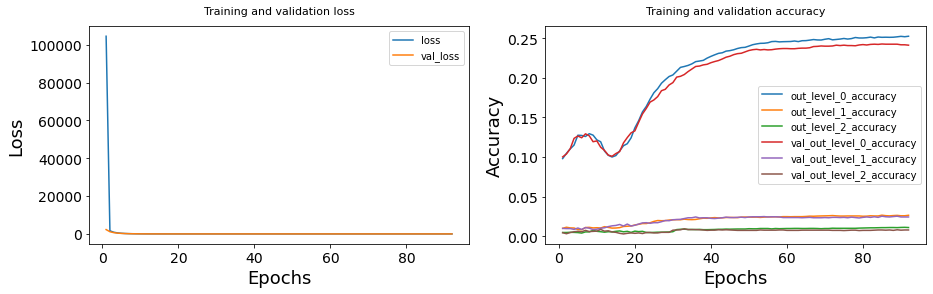

/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/MLPH_model_stanford_cars_vgg19/assets


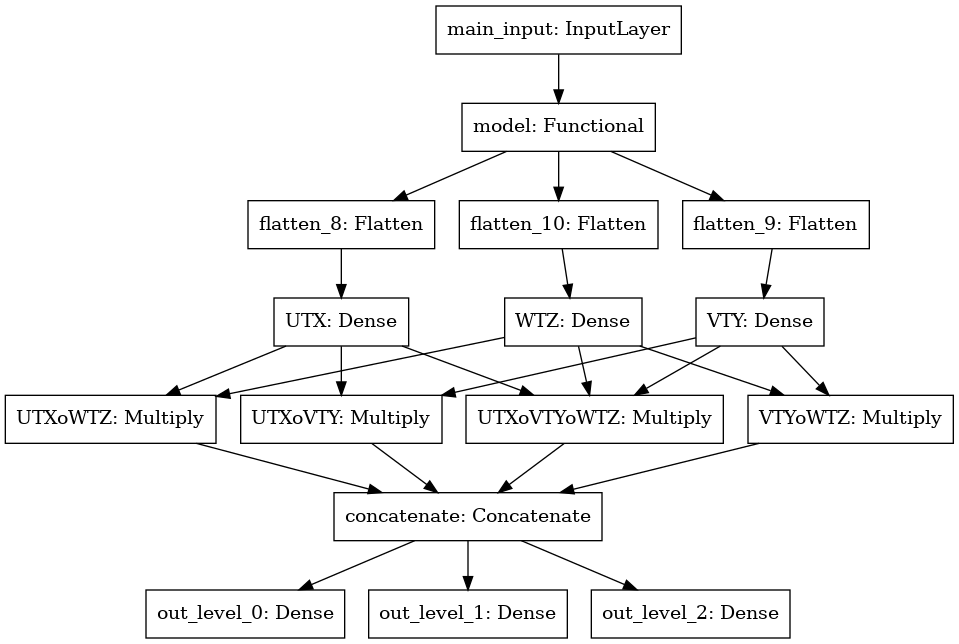

In [12]:
# Create the model
MLPH_model = models.get_MLPH_model(dataset.num_classes, 
                                   dataset.image_size)
MLPH_model.summary()
#train model
history_MLPH_model = MLPH_model.fit(dataset.X_train, 
                                    dataset.y_train,
                                    validation_data = (dataset.X_val, dataset.y_val), 
                                    batch_size=batch, 
                                    epochs=epochs,
                                    callbacks=[performance_callback_val, early_stopping_callback])
utils.learning_plots(history_MLPH_model)
MLPH_model.save("models/MLPH_model_" + dataset.name + "_" + conv_base)
plot_model(MLPH_model,show_shapes=False, expand_nested=False, dpi=96)


Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
output (Dense)               (None, 196)               401604    
Total params: 20,425,988
Trainable params: 20,425,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
64/64 [==============================] - 6s 88ms/step - loss: 9.3998 - accuracy: 0.0047 - val_loss: 5.3776 - val_accuracy: 0.0075
+-----------------------------------------------------------------------------+
|               

64/64 [==============================] - 5s 83ms/step - loss: 5.2306 - accuracy: 0.0106 - val_loss: 5.2869 - val_accuracy: 0.0060
+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0060 |  Consistency   | 1.0000 |       -        |   -    |
|  h-Precision   | 0.0516 |    h-Recall    | 0.0516 |   h-F1-Score   | 0.0516 |
|  Accuracy L_0  | 0.1336 |  Accuracy L_1  | 0.0152 |  Accuracy L_2  | 0.0060 |
| h-Accuracy-k=1 | 0.0125 | h-Accuracy-k=2 | 0.0205 | h-Accuracy-k=5 | 0.0518 |
| m-Accuracy-k=1 | 0.0516 | m-Accuracy-k=2 | 0.0678 | m-Accuracy-k=5 | 0.2143 |
+----------------+--------+----------------+--------+----------------+

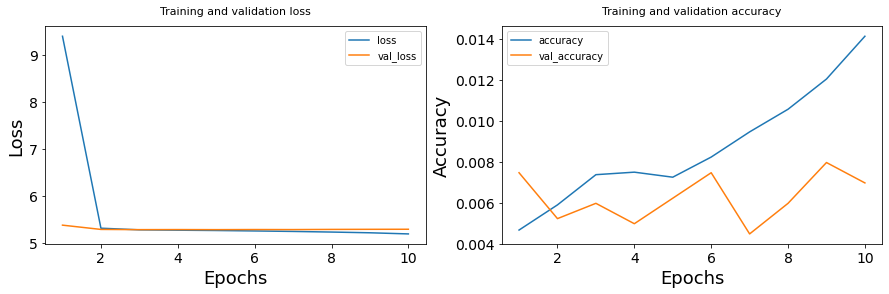

INFO:tensorflow:Assets written to: models/baseline_model_stanford_cars_vgg19/assets


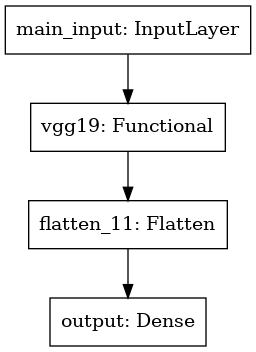

In [13]:
# Create the model
baseline_model = models.get_Baseline_model(dataset.num_classes, 
                                           dataset.image_size, 
                                           dataset.taxonomy, 
                                           conv_base=conv_base,
                                           learning_rate=learning_rate)
baseline_model.summary()
#train model
history_baseline_model = baseline_model.fit(dataset.X_train, 
                    dataset.y_train[-1],
                    validation_data = (dataset.X_val, dataset.y_val[-1]),
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback_val, early_stopping_callback])
utils.learning_plots(history_baseline_model)
baseline_model.save("models/baseline_model_" + dataset.name + "_" + conv_base)
plot_model(baseline_model)


Model: "Masked_Output_Net"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
main_input (InputLayer)                          [(None, 64, 64, 3)]                         0                
______________________________________________________________________________________________________________
vgg19 (Functional)                               (None, None, None, 512)                     20024384         
______________________________________________________________________________________________________________
flatten_12 (Flatten)                             (None, 2048)                                0                
______________________________________________________________________________________________________________
masked__output (Masked_Output)                   [(None, 13), (None, 113), (None, 196

64/64 [==============================] - 5s 85ms/step - loss: 4.0456 - masked__output_loss: 2.1255 - masked__output_1_loss: 4.7328 - masked__output_2_loss: 5.2784 - masked__output_accuracy: 0.2694 - masked__output_1_accuracy: 0.0151 - masked__output_2_accuracy: 0.0044 - val_loss: 4.0447 - val_masked__output_loss: 2.1275 - val_masked__output_1_loss: 4.7281 - val_masked__output_2_loss: 5.2784 - val_masked__output_accuracy: 0.2664 - val_masked__output_1_accuracy: 0.0154 - val_masked__output_2_accuracy: 0.0040
+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0006 |  Consistency   | 0.0475 |       -        |   -    |
|  h-Pre

+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0005 |  Consistency   | 0.1294 |       -        |   -    |
|  h-Precision   | 0.0979 |    h-Recall    | 0.1537 |   h-F1-Score   | 0.1186 |
|  Accuracy L_0  | 0.3020 |  Accuracy L_1  | 0.0201 |  Accuracy L_2  | 0.0037 |
| h-Accuracy-k=1 | 0.0093 | h-Accuracy-k=2 | 0.0229 | h-Accuracy-k=5 | 0.0598 |
| m-Accuracy-k=1 | 0.1086 | m-Accuracy-k=2 | 0.1879 | m-Accuracy-k=5 | 0.3063 |
+----------------+--------+----------------+--------+----------------+--------+
Epoch 8/100
64/64 [==============================] - 5s 84ms/step - loss: 3.9772 - masked__output_loss: 1.9663 - masked_

+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0031 |  Consistency   | 0.2254 |       -        |   -    |
|  h-Precision   | 0.1234 |    h-Recall    | 0.1763 |   h-F1-Score   | 0.1434 |
|  Accuracy L_0  | 0.3814 |  Accuracy L_1  | 0.0433 |  Accuracy L_2  | 0.0065 |
| h-Accuracy-k=1 | 0.0167 | h-Accuracy-k=2 | 0.0337 | h-Accuracy-k=5 | 0.0793 |
| m-Accuracy-k=1 | 0.1437 | m-Accuracy-k=2 | 0.2227 | m-Accuracy-k=5 | 0.3457 |
+----------------+--------+----------------+--------+----------------+--------+
+-----------------------------------------------------------------------------+
|                                Validat

64/64 [==============================] - 5s 85ms/step - loss: 3.8359 - masked__output_loss: 1.7204 - masked__output_1_loss: 4.5110 - masked__output_2_loss: 5.2763 - masked__output_accuracy: 0.4190 - masked__output_1_accuracy: 0.0592 - masked__output_2_accuracy: 0.0090 - val_loss: 3.9046 - val_masked__output_loss: 1.8677 - val_masked__output_1_loss: 4.5692 - val_masked__output_2_loss: 5.2770 - val_masked__output_accuracy: 0.3602 - val_masked__output_1_accuracy: 0.0488 - val_masked__output_2_accuracy: 0.0082
+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0052 |  Consistency   | 0.2615 |       -        |   -    |
|  h-Pre

+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0065 |  Consistency   | 0.2883 |       -        |   -    |
|  h-Precision   | 0.1371 |    h-Recall    | 0.1915 |   h-F1-Score   | 0.1576 |
|  Accuracy L_0  | 0.3828 |  Accuracy L_1  | 0.0515 |  Accuracy L_2  | 0.0119 |
| h-Accuracy-k=1 | 0.0284 | h-Accuracy-k=2 | 0.0477 | h-Accuracy-k=5 | 0.1000 |
| m-Accuracy-k=1 | 0.1488 | m-Accuracy-k=2 | 0.2328 | m-Accuracy-k=5 | 0.3619 |
+----------------+--------+----------------+--------+----------------+--------+
Epoch 19/100
64/64 [==============================] - 5s 84ms/step - loss: 3.7167 - masked__output_loss: 1.5489 - masked

+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0160 |  Consistency   | 0.2861 |       -        |   -    |
|  h-Precision   | 0.1880 |    h-Recall    | 0.2565 |   h-F1-Score   | 0.2138 |
|  Accuracy L_0  | 0.5561 |  Accuracy L_1  | 0.1142 |  Accuracy L_2  | 0.0200 |
| h-Accuracy-k=1 | 0.0496 | h-Accuracy-k=2 | 0.0836 | h-Accuracy-k=5 | 0.1645 |
| m-Accuracy-k=1 | 0.2301 | m-Accuracy-k=2 | 0.3127 | m-Accuracy-k=5 | 0.4393 |
+----------------+--------+----------------+--------+----------------+--------+
+-----------------------------------------------------------------------------+
|                                Validat

64/64 [==============================] - 5s 85ms/step - loss: 3.4361 - masked__output_loss: 1.2265 - masked__output_1_loss: 3.8655 - masked__output_2_loss: 5.2164 - masked__output_accuracy: 0.5959 - masked__output_1_accuracy: 0.1508 - masked__output_2_accuracy: 0.0275 - val_loss: 3.8467 - val_masked__output_loss: 1.8207 - val_masked__output_1_loss: 4.4530 - val_masked__output_2_loss: 5.2665 - val_masked__output_accuracy: 0.3858 - val_masked__output_1_accuracy: 0.0754 - val_masked__output_2_accuracy: 0.0174
+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0278 |  Consistency   | 0.2466 |       -        |   -    |
|  h-Pre

+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0104 |  Consistency   | 0.2353 |       -        |   -    |
|  h-Precision   | 0.1503 |    h-Recall    | 0.2143 |   h-F1-Score   | 0.1743 |
|  Accuracy L_0  | 0.3826 |  Accuracy L_1  | 0.0791 |  Accuracy L_2  | 0.0194 |
| h-Accuracy-k=1 | 0.0449 | h-Accuracy-k=2 | 0.0783 | h-Accuracy-k=5 | 0.1492 |
| m-Accuracy-k=1 | 0.1604 | m-Accuracy-k=2 | 0.2528 | m-Accuracy-k=5 | 0.3991 |
+----------------+--------+----------------+--------+----------------+--------+


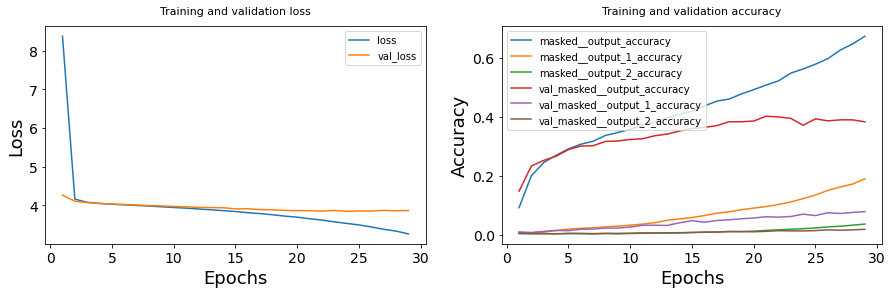

INFO:tensorflow:Assets written to: models/mcnn_model_stanford_cars_vgg19/assets


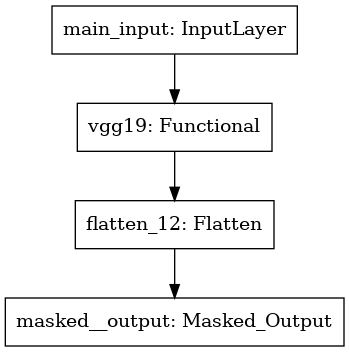

In [14]:
# tensorboard = TensorBoard(log_dir='/tmp/logs', histogram_freq=0,
#                           write_graph=True, write_images=False)
# Create the model
mcnn_model = models.get_Masked_Output_Net(dataset.num_classes,
                                          dataset.image_size,
                                          dataset.taxonomy,
                                          conv_base=conv_base,
                                          learning_rate=learning_rate)
mcnn_model.summary(line_length=110)
#train model
history_mcnn_model_model = mcnn_model.fit(dataset.X_train, 
                                          dataset.y_train,
                                          validation_data = (dataset.X_val, dataset.y_val),
                                          batch_size=batch, 
                                          epochs=epochs,
                                          callbacks=[performance_callback_train,
                                                     performance_callback_val, 
#                                                      tensorboard, 
                                                     early_stopping_callback
                                                    ])
utils.learning_plots(history_mcnn_model_model)
mcnn_model.save("models/mcnn_model_" + dataset.name + "_" + conv_base)
plot_model(mcnn_model)


Model: "Masked_Output_Net"
______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
main_input (InputLayer)             [(None, 64, 64, 3)]     0                                                 
______________________________________________________________________________________________________________
conv_base_mcnn_0 (Functional)       (None, None, None, 512) 20024384     main_input[0][0]                     
______________________________________________________________________________________________________________
conv_base_mcnn_1 (Functional)       (None, None, None, 512) 20024384     main_input[0][0]                     
______________________________________________________________________________________________________________
conv_base_mcnn_2 (Functional)       (None, None, None, 512) 20024384     main_input[0

+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0010 |  Consistency   | 0.1667 |       -        |   -    |
|  h-Precision   | 0.0928 |    h-Recall    | 0.1427 |   h-F1-Score   | 0.1113 |
|  Accuracy L_0  | 0.2555 |  Accuracy L_1  | 0.0204 |  Accuracy L_2  | 0.0067 |
| h-Accuracy-k=1 | 0.0149 | h-Accuracy-k=2 | 0.0238 | h-Accuracy-k=5 | 0.0569 |
| m-Accuracy-k=1 | 0.0942 | m-Accuracy-k=2 | 0.1625 | m-Accuracy-k=5 | 0.2833 |
+----------------+--------+----------------+--------+----------------+--------+
Epoch 4/100
64/64 [==============================] - 15s 229ms/step - loss: 4.0545 - masked__output_1_loss: 2.1560 - mas

+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0065 |  Consistency   | 0.2692 |       -        |   -    |
|  h-Precision   | 0.1225 |    h-Recall    | 0.1732 |   h-F1-Score   | 0.1416 |
|  Accuracy L_0  | 0.3190 |  Accuracy L_1  | 0.0476 |  Accuracy L_2  | 0.0138 |
| h-Accuracy-k=1 | 0.0310 | h-Accuracy-k=2 | 0.0524 | h-Accuracy-k=5 | 0.1004 |
| m-Accuracy-k=1 | 0.1268 | m-Accuracy-k=2 | 0.2041 | m-Accuracy-k=5 | 0.3336 |
+----------------+--------+----------------+--------+----------------+--------+
+-----------------------------------------------------------------------------+
|                                Validat

64/64 [==============================] - 15s 230ms/step - loss: 3.8745 - masked__output_1_loss: 1.8959 - masked__output_1_1_loss: 4.5071 - masked__output_1_2_loss: 5.2205 - masked__output_1_accuracy: 0.3603 - masked__output_1_1_accuracy: 0.0603 - masked__output_1_2_accuracy: 0.0260 - val_loss: 3.9434 - val_masked__output_1_loss: 1.9719 - val_masked__output_1_1_loss: 4.5851 - val_masked__output_1_2_loss: 5.2731 - val_masked__output_1_accuracy: 0.3164 - val_masked__output_1_1_accuracy: 0.0458 - val_masked__output_1_2_accuracy: 0.0142
+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0199 |  Consistency   | 0.3158 |       - 

+-----------------------------------------------------------------------------+
|                                Validation set                               |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0100 |  Consistency   | 0.3042 |       -        |   -    |
|  h-Precision   | 0.1314 |    h-Recall    | 0.1825 |   h-F1-Score   | 0.1506 |
|  Accuracy L_0  | 0.3398 |  Accuracy L_1  | 0.0547 |  Accuracy L_2  | 0.0199 |
| h-Accuracy-k=1 | 0.0420 | h-Accuracy-k=2 | 0.0682 | h-Accuracy-k=5 | 0.1231 |
| m-Accuracy-k=1 | 0.1381 | m-Accuracy-k=2 | 0.2253 | m-Accuracy-k=5 | 0.3549 |
+----------------+--------+----------------+--------+----------------+--------+
Epoch 15/100
64/64 [==============================] - 15s 229ms/step - loss: 3.7145 - masked__output_1_loss: 1.7583 - ma

+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.0785 |  Consistency   | 0.2905 |       -        |   -    |
|  h-Precision   | 0.2211 |    h-Recall    | 0.2875 |   h-F1-Score   | 0.2461 |
|  Accuracy L_0  | 0.4792 |  Accuracy L_1  | 0.1513 |  Accuracy L_2  | 0.1049 |
| h-Accuracy-k=1 | 0.1645 | h-Accuracy-k=2 | 0.2136 | h-Accuracy-k=5 | 0.2960 |
| m-Accuracy-k=1 | 0.2451 | m-Accuracy-k=2 | 0.3349 | m-Accuracy-k=5 | 0.4608 |
+----------------+--------+----------------+--------+----------------+--------+
+-----------------------------------------------------------------------------+
|                                Validat

64/64 [==============================] - 15s 230ms/step - loss: 3.2674 - masked__output_1_loss: 1.4534 - masked__output_1_1_loss: 3.7142 - masked__output_1_2_loss: 4.6347 - masked__output_1_accuracy: 0.5363 - masked__output_1_1_accuracy: 0.2033 - masked__output_1_2_accuracy: 0.1462 - val_loss: 3.9407 - val_masked__output_1_loss: 1.8591 - val_masked__output_1_1_loss: 4.5302 - val_masked__output_1_2_loss: 5.4329 - val_masked__output_1_accuracy: 0.3716 - val_masked__output_1_1_accuracy: 0.0709 - val_masked__output_1_2_accuracy: 0.0251
+-----------------------------------------------------------------------------+
|                                 Training set                                |
+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 0.1373 |  Consistency   | 0.3075 |       - 

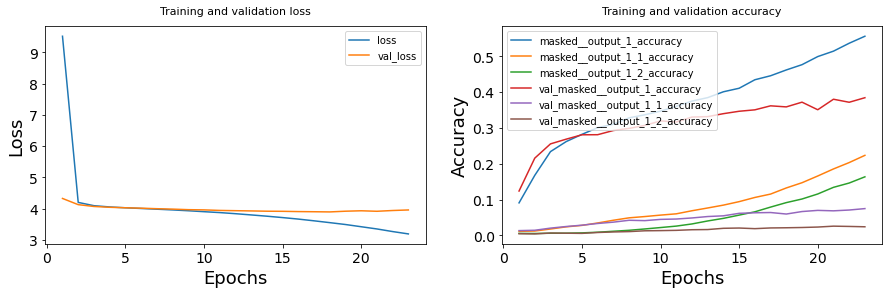

INFO:tensorflow:Assets written to: models/mcnn_mnets_model_stanford_cars_vgg19/assets


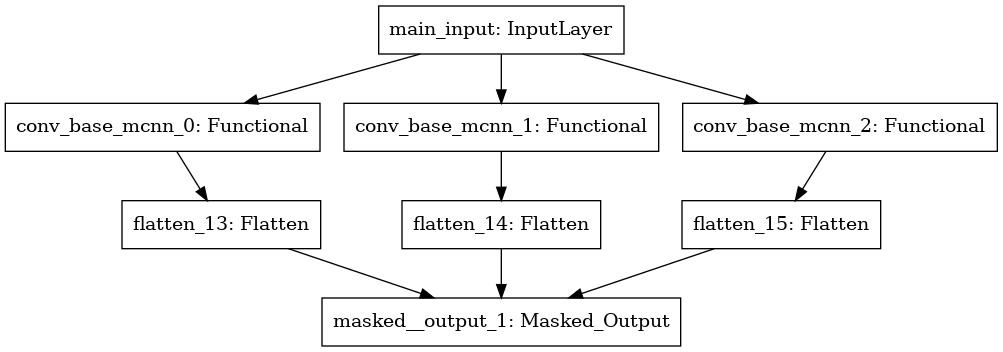

In [15]:
# Create the model
mcnn_mnets_model = models.get_Masked_Output_Net(dataset.num_classes,
                                                dataset.image_size,
                                                dataset.taxonomy,
                                                conv_base=conv_base,
                                                learning_rate=learning_rate,
                                                mnets=True)
mcnn_mnets_model.summary(line_length=110)
#train model
history_mcnn_mnets_model = mcnn_mnets_model.fit(dataset.X_train, 
                                                dataset.y_train,
                                                validation_data=(dataset.X_val, dataset.y_val), 
                                                batch_size=batch, 
                                                epochs=epochs,
                                                callbacks=[performance_callback_train,
                                                           performance_callback_val,  
#                                                            tensorboard, 
                                                           early_stopping_callback
                                                          ])
utils.learning_plots(history_mcnn_mnets_model)
mcnn_mnets_model.save("models/mcnn_mnets_model_" + dataset.name + "_" + conv_base)
plot_model(mcnn_mnets_model)


In [16]:
mcnn_model_pred = mcnn_model.predict(dataset.X_test)
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=2))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=3))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=4))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=5))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=6))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=7))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=8))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=9))
print(metrics.get_h_accuracy(dataset.y_test, mcnn_model_pred, k=10))


0.07343026543443343
0.09760136868195032
0.12515430489325868
0.1489264718934386
0.17171343713826104
0.19064987394964827
0.20833848922962075
0.2262807192058652
0.23892174437055613


In [ ]:
BCNN2_reversed_pred = BCNN2_reversed_model.predict(dataset.X_test)
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=2))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=3))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=4))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=5))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=6))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=7))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=8))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=9))
print(metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=10))


In [ ]:
# Make predictions on the test set
mout_pred = mout_model.predict(dataset.X_test)
BCNN1_pred = BCNN1_model.predict(dataset.X_test)
BCNN1_reversed_pred = BCNN1_reversed_model.predict(dataset.X_test)
BCNN2_pred = BCNN2_model.predict(dataset.X_test)
BCNN2_reversed_pred = BCNN2_reversed_model.predict(dataset.X_test)
mnets_pred = mnets_model.predict(dataset.X_test)
baseline_pred = baseline_model.predict(dataset.X_test)
MLPH_pred = MLPH_model.predict(dataset.X_test)
mcnn_pred = mcnn_model.predict(dataset.X_test)
mcnn_mnets_pred = mcnn_mnets_model.predict(dataset.X_test)

In [ ]:
exact_match_scores = [metrics.get_exact_match(dataset.y_test, mout_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN1_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN1_reversed_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN2_pred),
                      metrics.get_exact_match(dataset.y_test, BCNN2_reversed_pred),
                      metrics.get_exact_match(dataset.y_test, mnets_pred),
                      metrics.get_exact_match(dataset.y_test, baseline_pred),
                      metrics.get_exact_match(dataset.y_test, MLPH_pred),
                      metrics.get_exact_match(dataset.y_test, mcnn_pred)]

h_accuracy_scores = [metrics.get_h_accuracy(dataset.y_test, mout_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred),
                     metrics.get_h_accuracy(dataset.y_test, mnets_pred),
                     metrics.get_h_accuracy(dataset.y_test, baseline_pred), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred), 
                     metrics.get_h_accuracy(dataset.y_test, mcnn_pred)]

h_accuracy_scores_k2 = [metrics.get_h_accuracy(dataset.y_test, mout_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, mnets_pred, k=2),
                     metrics.get_h_accuracy(dataset.y_test, baseline_pred, k=2), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred, k=2), 
                     metrics.get_h_accuracy(dataset.y_test, mcnn_pred, k=2)]

h_accuracy_scores_k5 = [metrics.get_h_accuracy(dataset.y_test, mout_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN1_reversed_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, BCNN2_reversed_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, mnets_pred, k=5),
                     metrics.get_h_accuracy(dataset.y_test, baseline_pred, k=5), 
                     metrics.get_h_accuracy(dataset.y_test, MLPH_pred, k=5), 
                     metrics.get_h_accuracy(dataset.y_test, mcnn_pred, k=5)]

m_accuracy_scores = [metrics.get_m_accuracy(dataset.y_test, mout_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN1_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN1_reversed_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN2_pred),
                     metrics.get_m_accuracy(dataset.y_test, BCNN2_reversed_pred),
                     metrics.get_m_accuracy(dataset.y_test, mnets_pred),
                     metrics.get_m_accuracy(dataset.y_test, baseline_pred),
                     metrics.get_m_accuracy(dataset.y_test, MLPH_pred),
                     metrics.get_m_accuracy(dataset.y_test, mcnn_pred)]


consistency = [metrics.get_consistency(mout_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN1_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN1_reversed_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN2_pred, dataset.taxonomy),
               metrics.get_consistency(BCNN2_reversed_pred, dataset.taxonomy),
               metrics.get_consistency(mnets_pred, dataset.taxonomy),
               metrics.get_consistency(baseline_pred, dataset.taxonomy),
               metrics.get_consistency(MLPH_pred, dataset.taxonomy),
               metrics.get_consistency(mcnn_pred, dataset.taxonomy)]

# Create example dataframe
df = pd.DataFrame({
'exact_match': exact_match_scores,
'h_accuracy': h_accuracy_scores,
'h_accuracy_k2': h_accuracy_scores_k2,
'h_accuracy_k5': h_accuracy_scores_k5,
'm_accuracy': m_accuracy_scores,
'consistency': consistency,
's': [3000,3000,3000,3000,3000,3000,3000,3000,3000],
'algo': ['mout','BCNN1','BCNN1_R','BCNN2','BCNN2_R', 'mnets', 'baseline', 'MLPH', 'M-CNN']
})


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.exact_match, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.xlabel('Exact Match')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_em.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy_k2, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy k=2')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy_k2[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy_k2.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.h_accuracy_k5, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Harmonic Accuracy k=5')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.h_accuracy_k5[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_h_accuracy_k5.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.m_accuracy, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Mean Accuracy')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.m_accuracy[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot_m_accuracy.pdf', bbox_inches = 'tight')
plt.show()


# This section is used for debugging

In [ ]:
# Create the model
i = 2
baseline_model = m.get_Classifier_model(num_classes[i], 
                                           dataset.image_size, 
                                           conv_base='vgg19',
                                           learning_rate=1e-5,
                                            lam=0.0001)
baseline_model.summary()
#train model
history_baseline_model = baseline_model.fit(dataset.X_train, 
                    dataset.y_train[i],
                    validation_data = (dataset.X_val, dataset.y_val[i]),
                    batch_size=batch, 
                    epochs=200,
                    )
plot_model(baseline_model)


In [ ]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, \
    GlobalAveragePooling2D, Multiply, Concatenate, experimental
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, VGG16, ResNet50, Xception


i = 2
in_layer = Input(shape=dataset.image_size)
rescale = experimental.preprocessing.Rescaling(1. / 255)(in_layer)
conv_base = VGG19(include_top=False, weights="imagenet")(rescale)
conv_base = Flatten()(conv_base)
# create output layers
out_layer = Dense(num_classes[i], activation="softmax")(conv_base)
# Build the model
model = Model(inputs=in_layer,
              outputs=out_layer)
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
model.summary()


history_baseline_model = model.fit(dataset.X_val, 
                    dataset.y_val[i],
                    validation_data = (dataset.X_val, dataset.y_val[i]),
                    batch_size=batch, 
                    epochs=200,
                    )
plot_model(baseline_model)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections
import itertools
from keras.applications.efficientnet import EfficientNetB0


In [ ]:
# Defining your model here:
i = 2
model = models.Sequential()
model.add(keras.Input(shape=dataset.image_size)) 
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(EfficientNetB0(weights='imagenet', include_top=False))
#Dense part
model.add(layers.Flatten())
model.add(layers.Dense(num_classes[i], activation='softmax'))
# Print a summary of the model
loss = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

model.summary()

history_baseline_model = model.fit(dataset.X_train, 
                    dataset.y_train[i],
                    validation_data = (dataset.X_val, dataset.y_val[i]),
                    batch_size=batch, 
                    epochs=200,
                    )
plot_model(baseline_model)


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report
from tensorflow.keras import models, layers, optimizers
from tensorflow.python.keras.saving import hdf5_format
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import h5py, itertools, collections
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

##################
# Verifications:
#################
print('GPU is used.' if len(tf.config.list_physical_devices('GPU')) > 0 else 'GPU is NOT used.')
print("Tensorflow version: " + tf.__version__)

In [ ]:
'''
    Split train and validation.
'''
# We define the size of input images to 128x128 pixels.
image_size = (256, 256)
# We define the batch size
batch_size = 32

# Create an image generator with a fraction of images reserved for validation:
image_generator = ImageDataGenerator(
                                     validation_split=0.5)

# Now, we create a training data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
train_ds =  DirectoryIterator(
    "dataset/",
    image_generator,
    class_mode='categorical',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'training',
)

# Similarly, we create a validation data iterator by creating batchs of images of the same size as 
# defined previously, i.e., each image is resized in a 64x64 pixels format.
val_ds = DirectoryIterator(
    "dataset/",
    image_generator,
    class_mode='categorical',
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
    subset = 'validation',
    shuffle=False
)

# We save the list of classes (labels).
class_names = list(train_ds.class_indices.keys())

# We also save the number of labels.
num_classes = train_ds.num_classes


In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=image_size + (3,),
                                               include_top=False,
                                               weights='imagenet')
# base_model.trainable = False


In [ ]:
# # Defining your model here:
model = models.Sequential()
# model.add(keras.Input(shape=image_size + (3,))) 
# model.add(layers.experimental.preprocessing.Rescaling(1./255))
# model.add(VGG19(input_shape=image_size + (3,), include_top=False, weights="imagenet"))

model.add(base_model)
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
# Print a summary of the model
model.summary()

base_learning_rate = 0.0001
model.compile(optimizers.Adam(learning_rate = base_learning_rate),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Start the trining by defining the number of epochs to train, the traing set and the validation set.
history = model.fit(train_ds, epochs=100,
    validation_data=val_ds,
)


In [ ]:
performance_callback_val = models.performance_callback(dataset.X_val, 
                                                       dataset.y_val, 
                                                       dataset.get_tree(),
                                                       name='Validation set')

In [63]:
mcnn_model_pred = mcnn_model.predict(dataset.X_test)


In [64]:
mcnn_model_pred

[array([[9.88866866e-01, 1.11331325e-02],
        [9.99726117e-01, 2.73895799e-04],
        [9.99989748e-01, 1.02361537e-05],
        ...,
        [9.98040378e-01, 1.95962074e-03],
        [9.99399424e-01, 6.00514584e-04],
        [9.99443829e-01, 5.56107145e-04]], dtype=float32),
 array([[1.17205971e-04, 7.85362572e-05, 6.04864908e-04, ...,
         9.85175431e-01, 1.07732565e-04, 1.05697007e-04],
        [2.12594117e-07, 4.38602001e-04, 1.91837847e-02, ...,
         5.56557552e-06, 1.64415123e-05, 1.64231296e-05],
        [1.56069740e-10, 1.43709534e-04, 9.99791086e-01, ...,
         4.51496671e-05, 5.31027702e-08, 5.31045927e-08],
        ...,
        [1.17907628e-04, 5.02176862e-03, 3.18736732e-02, ...,
         2.55071610e-01, 7.78757967e-04, 7.73749489e-04],
        [2.93667040e-06, 4.87271063e-05, 3.41831793e-07, ...,
         1.80605912e-05, 4.78266929e-06, 4.76457308e-06],
        [6.31334979e-06, 6.32534362e-03, 1.04333786e-02, ...,
         5.40555277e-07, 3.51991075e-05, 3.

In [72]:
pred= []
pred.append(to_categorical(dataset.y_test[0], num_classes=2))
pred.append(to_categorical(dataset.y_test[1], num_classes=20))
pred.append(to_categorical(dataset.y_test[2], num_classes=100))


In [74]:
metrics.performance_report(dataset.y_test, pred, dataset.get_tree())

+----------------+--------+----------------+--------+----------------+--------+
|    Metric1     | Value1 |    Metric2     | Value2 |    Metric3     | Value3 |
+----------------+--------+----------------+--------+----------------+--------+
|  Exact Match   | 1.0000 |  Consistency   | 1.0000 |       -        |   -    |
|  h-Precision   | 1.0000 |    h-Recall    | 1.0000 |   h-F1-Score   | 1.0000 |
|  Accuracy L_0  | 1.0000 |  Accuracy L_1  | 1.0000 |  Accuracy L_2  | 1.0000 |
| h-Accuracy-k=1 | 1.0000 | h-Accuracy-k=2 | 1.0000 | h-Accuracy-k=5 | 1.0000 |
| m-Accuracy-k=1 | 1.0000 | m-Accuracy-k=2 | 1.0000 | m-Accuracy-k=5 | 1.0000 |
+----------------+--------+----------------+--------+----------------+--------+
